I tried these THEANO flags at the prompt:   

```     
THEANO_FLAGS='mode=FAST_RUN,floatX=float32,device=gpu0,lib.cnmem=0.80,optimizer_excluding=low_memory' jupyter notebook

```    

In [1]:
%matplotlib inline

In [2]:
from collections import namedtuple

In [3]:
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import pandas as pd

In [4]:
import theano

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)
/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [5]:
from theano import function, config, sandbox, shared 
import theano.tensor as T

In [6]:
import numpy as np
import scipy
import time

In [7]:
print( theano.config.device )
print( theano.config.lib.cnmem)  # cf. http://deeplearning.net/software/theano/library/config.html
print( theano.config.print_active_device)# Print active device at when the GPU device is initialized.

gpu0
0.8
True


In [8]:
import os, sys
os.getcwd()

'/home/topolo/PropD/MLgrabbag'

In [9]:
%run gpu_test.py THEANO_FLAGS='mode=FAST_RUN,device=gpu,floatX=float32,lib.cnmem=0.65' # note lib.cnmem option for CnMem

[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.221608 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [9]:
print(theano.config.allow_gc)
print(theano.config.optimizer_excluding)

False



In [10]:
# cf. http://deeplearning.net/software/theano/faq.html
theano.config.allow_gc=False
print(theano.config.allow_gc)

False


In [11]:
"""A list of optimizer tags that we don’t want included in the default Mode. 
If multiple tags, separate them by ‘:’. 
Ex: to remove the elemwise inplace optimizer(slow for big graph), 
use the flags: optimizer_excluding:inplace_opt, where inplace_opt is the name of that optimization."""
theano.config.optimizer_excluding

'low_memory'

cf. [Theano memory/speed trade-off](http://deeplearning.net/software/theano/faq.html)

"Could raise memory usage but speed up computation:"
Try this:

In [25]:
config.optimizer_excluding ="low_memory" 

Exception: Can't change the value of this config parameter after initialization!

In [10]:
from six.moves import cPickle

# Notes on *`scan`*; using `theano.scan`, what is scan

cf. http://deeplearning.net/software/theano/library/scan.html

```  
    theano.scan(fn,
                sequences=None,
                outputs_info, 
                non_sequences=None
                mode=None,name=None)   
    
```      

* `fn` function should expect as input: theano variables, representing all slices of input sequences, and previous output values  
    - order of sequences is same as one in list `sequences` 
    - order of outputs of this function is same as order of `outputs_info`
* `sequences` - list of Theano variables or dictionaries describing the sequences `scan` has to iterate over 
* `outputs_info` - list of theano varialbes or dictionaries describing the initial state of outputs computed recurrently
    
    

# RNN (Recurrent Neural Networks), LSTM (Long Short-Term Memory)

In [11]:
import reberGrammar

In [10]:
train_data = reberGrammar.get_one_embedded_example() # pair (train-sequence, target-sequence)

In [12]:
train_data = reberGrammar.get_n_embedded_examples(1000)

In [12]:
print(type(train_data)); print(len(train_data)); print(type(train_data[0])); print(len(train_data[0])); 
print(len(train_data[1]))
#for arr in eg00[0]:
#    print(type(arr)); print(arr.shape)
print(type(train_data[0][0])); print(train_data[0][0].shape)
print(type(train_data[1][0])); print(train_data[1][0].shape)

<type 'tuple'>
2
<type 'list'>
15
15
<type 'numpy.ndarray'>
(7,)
<type 'numpy.ndarray'>
(7,)


In [14]:
# for example
print( train_data[0][0])
train_data[1]

[ 1.  0.  0.  0.  0.  0.  0.]


[array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.])]

In [15]:
X_train_data = train_data[0]
y_train_data = train_data[1]

In [28]:
print(type(train_data)); print(len(train_data)); print(type(train_data[0])); 
print(len(train_data[0])); print( type( train_data[0][0] ) ) ; print( len(train_data[0][0])); 
print( type(train_data[0][0][0])) ; print( train_data[0][0][0].shape)

<type 'list'>
1000
<type 'tuple'>
2
<type 'list'>
14
<type 'numpy.ndarray'>
(7,)


In [17]:
pd.DataFrame(X_train_data).describe()

,0,1,2,3,4,5,6
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.133333,0.133333,0.266667,0.133333,0.200000,0.066667,0.066667
std,0.351866,0.351866,0.457738,0.351866,0.414039,0.258199,0.258199
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
index = np.random.randint(0, len(train_data)); print(index);
i,o = train_data[index]; print(i[0]); print(o[0])

853
[ 1.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  1.  0.  0.]


In [17]:
train_data = reberGrammar.get_n_embedded_examples(1000)

NameError: name 'reberGrammar' is not defined

In [11]:
print( type(train_data)); print(len(train_data)); print(type( train_data[0]));print(len(train_data[0]));
print(type(train_data[0][0])); print(type(train_data[0][1])); print(len(train_data[0][0]));print(len(train_data[0][1]))
print(type(train_data[0][0][0])); print(train_data[0][0][0].shape)

<type 'list'>
1000
<type 'tuple'>
2
<type 'list'>
<type 'list'>
14
14
<type 'numpy.ndarray'>
(7,)


In [12]:
index=np.random.randint(0,len(train_data)); print(index)

908


In [13]:
i,o = train_data[index]
print(type(i));print(type(o));print(len(i));print(len(o))

<type 'list'>
<type 'list'>
14
14


Split up `train_data` into input training examples $X$, and output data $y$, each a function of time $t=0,1,\dots T-1$, where $T=1000$ in this case.  

In [30]:
X_train_datat, y_train_datat = zip(*train_data)

In [36]:
print(type(X_train_datat)); print(len(X_train_datat)); print(type(X_train_datat[0]));print(len(X_train_datat[0]))
X_train_datat[0]

<type 'tuple'>
1000
<type 'list'>
17


[array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.])]

In [37]:
print(type(y_train_datat)); print(len(y_train_datat)); print(type(y_train_datat[0]));print(len(y_train_datat[0]))
y_train_datat[0]

<type 'tuple'>
1000
<type 'list'>
17


[array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.])]

In [40]:
dtype=theano.config.floatX
#TODO: Use a more appropriate initialization method
def sample_weights(sizeX, sizeY):
    values = np.ndarray([sizeX, sizeY], dtype=dtype)
    for dx in xrange(sizeX):
        vals = np.random.uniform(low=-1., high=1.,  size=(sizeY,))
        #vals_norm = np.sqrt((vals**2).sum())
        #vals = vals / vals_norm
        values[dx,:] = vals
    _,svs,_ = np.linalg.svd(values)
    #svs[0] is the largest singular value                      
    values = values / svs[0]
    return values  

In [42]:
sample_weights(7,10).shape

(7, 10)

## Herta's LSTM

In [15]:
sys.path.append( os.getcwd() + '/ML' )

import in my code from the folder `./ML`

In [15]:
from LSTM import Gates, Thetab, ThetabthetaW

In [16]:
from LSTM_Herta import *
#from LSTM_Herta import Gates, Psis, Thetab_right, Thetabtheta_right, ThetabthetaW, Feedforward_g_right, Feedforward_ifo_right, LSTM_Model_right, MemoryBlock_right

In [17]:
L_Herta = Gates(g=2,i=2,f=2,o=2)

n_hidden = n_i = n_c = n_o = n_f = 10
n_in = 7 # for embedded reber grammar
n_y = 7 # for embedded reber grammar; this is K in my notation

s_l_Herta = Gates(g=[n_in,n_c],i=[n_in,n_i],f=[n_in,n_f],o=[n_in,n_o])

activations_Herta = Psis(g=(T.tanh, T.tanh), i=(T.nnet.sigmoid, T.nnet.sigmoid),f=(T.nnet.sigmoid, T.nnet.sigmoid),
                         o=(T.nnet.sigmoid, T.nnet.sigmoid),h=(T.tanh,))


In [18]:
LSTM_model_Herta=LSTM_Model_right(L_Herta,s_l_Herta,n_hidden,n_y,activations_Herta,T.nnet.sigmoid )
lstm_step_fxn = LSTM_model_Herta.build_lstm_step()
MemBlck_Herta = MemoryBlock_right(n_hidden,LSTM_model_Herta)
MemBlck_Herta.build_scan_over_t()
MemBlck_Herta.build_J(0.1)

Total number of parameters: 17 


Elemwise{add,no_inplace}.0

In [19]:
MemBlck_Herta.build_update()

In [20]:
%time results_Herta_prelim = MemBlck_Herta.train_rnn(train_data,2)  # theano.config.allow_gc =:  False
# CPU times: user 20.5 s, sys: 10.3 s, total: 30.8 s
# Wall time: 30.7 s


theano.config.allow_gc =:  False
CPU times: user 20.5 s, sys: 10.3 s, total: 30.8 s
Wall time: 30.7 s


In [20]:
%time results_Herta_prelim = MemBlck_Herta.train_rnn(train_data,2) # theano.config.allow_gc =:  False
# CPU times: user 20.4 s, sys: 4.79 s, total: 25.2 s
# Wall time: 25.2 s # NOTE EY: 20170224, I added the optimizer_excluding=low_memory flag

theano.config.allow_gc =:  False
CPU times: user 20.4 s, sys: 4.79 s, total: 25.2 s
Wall time: 25.2 s


In [22]:
%time results_Herta = MemBlck_Herta.train_rnn(train_data)  # theano.config.allow_gc =:  False
# CPU times: user 41min 31s, sys: 10min 9s, total: 51min 40s
# Wall time: 51min 39s


theano.config.allow_gc =:  False
CPU times: user 41min 31s, sys: 10min 9s, total: 51min 40s
Wall time: 51min 39s


In [21]:
%time results_Herta = MemBlck_Herta.train_rnn(train_data) # I don't think optimizer_excluding=low_memory helps # theano.config.allow_gc =:  False
#CPU times: user 42min 32s, sys: 10min 49s, total: 53min 22s
#Wall time: 53min 20s

theano.config.allow_gc =:  False
CPU times: user 42min 32s, sys: 10min 49s, total: 53min 22s
Wall time: 53min 20s


<type 'numpy.ndarray'>
250


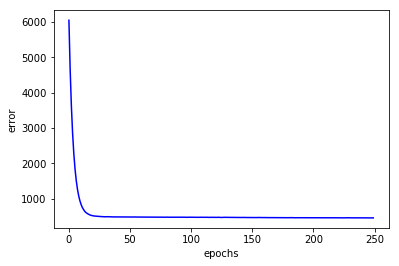

In [22]:
print(type(results_Herta)); print(len(results_Herta)); 
plt.plot(np.arange(250), results_Herta, 'b-')
plt.xlabel('epochs')
plt.ylabel('error')
#plt.ylim(0., 50)

In [ ]:
%time results_full = MemBlck_Herta.train_model_full(train_data)

In [20]:
test_data = reberGrammar.get_n_embedded_examples(10)

In [30]:
# automatically
# MemBlck_Herta.predict(test_data)

# manually,
#predictions = theano.function(inputs=[MemBlck_Herta.X], outputs=MemBlck_Herta.scan_res[0][-1])

def predict_on_lst_manual(test_data, verbose=True):
    predictions=[]
    for i,o in test_data:
        predictions_func = theano.function(inputs=[MemBlck_Herta.X],outputs=MemBlck_Herta.scan_res[0][-1])
        predicted_y = predictions_func(i)
        
        if verbose:
            print o[-2]
            print predicted_y[-2]

            print np.argmax( o[-2] )
            print np.argmax( predicted_y[-2] )

            
        predictions.append( predicted_y)
    return predictions

predictions_test  = predict_on_lst_manual(test_data)


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc969e2c90>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  1.  0.  0.  0.  0.  0.]
[ 0.03654994  0.22352684  0.17996094  0.17996106  0.27605593  0.25267285
  0.27077496]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc962f09d0>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  1.  0.  0.  0.  0.  0.]
[ 0.03652277  0.22360229  0.18104303  0.18104315  0.27559629  0.25401294
  0.2690331 ]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc95e9c750>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  0.  0.  0.  1.  0.  0.]
[ 0.03623551  0.21539557  0.15901656  0.15901668  0.28735468  0.22797918
  0.31401905]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc95b317d0>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  0.  0.  0.  1.  0.  0.]
[ 0.03653074  0.2218926   0.18212698  0.18212706  0.27314919  0.2502594
  0.27180815]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc957602d0>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  0.  0.  0.  1.  0.  0.]
[ 0.03678124  0.2233016   0.17556426  0.17556438  0.27802235  0.24592921
  0.27813935]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc954ef490>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  1.  0.  0.  0.  0.  0.]
[ 0.03789635  0.35366094  0.22607996  0.2260799   0.25579727  0.45357969
  0.1161061 ]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc959eed10>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  1.  0.  0.  0.  0.  0.]
[ 0.03562396  0.20534104  0.14943017  0.14943029  0.29428062  0.21335547
  0.34463325]
[ 0.  1.  0.  0.  0.  0.  0.]
[ 0.03593003  0.20925818  0.15188682  0.15188695  0.29261521  0.21754707
  0.33451572]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc9697c110>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  0.  0.  0.  1.  0.  0.]
[ 0.03678124  0.2233016   0.17556426  0.17556438  0.27802235  0.24592921
  0.27813935]
[ 0.  1.  0.  0.  0.  0.  0.]
[ 0.03415391  0.23968399  0.1267381   0.12673819  0.31862083  0.2563501
  0.32694301]


In [21]:
# j=0,1,...m-1, m=10 training pts.
print(type(test_data));print(len(test_data));print(type(test_data[0]));print(len(test_data[0]));
print(type(test_data[0][0])); print(len(test_data[0][0]));
X_test_data,y_test_data=map( list, zip(*test_data) )
print(type(X_test_data));print(len(X_test_data));print(type(y_test_data));print(len(y_test_data))

<type 'list'>
10
<type 'tuple'>
2
<type 'list'>
14
<type 'list'>
10
<type 'list'>
10


In [47]:
print(type(X_test_data[0]));print(len(X_test_data[0]));
print(test_data[0][0] == X_test_data[0])


<type 'list'>
14
True


In [40]:
len(test_data[0][0])

14

In [49]:
print(type(predictions_test));print(len(predictions_test));print(type(predictions_test[0]));print(len(predictions_test[0]))
print(predictions_test[0].shape)

<type 'list'>
10
<type 'numpy.ndarray'>
14
(14, 7)


In [53]:
np.argmax( predictions_test[0],axis=1 )

array([1, 1, 1, 3, 1, 1, 3, 5, 5, 5, 5, 5, 4, 6])

In [60]:
print(type(y_test_data[0])); print(len(y_test_data[0]));
[ np.argmax(row_t) for row_t in y_test_data[0]]

<type 'list'>
14


[1, 0, 1, 1, 1, 4, 2, 1, 1, 1, 4, 6, 1, 6]

In [57]:
np.equal( np.array( [np.argmax(row_t) for row_t in y_test_data[0]]), np.argmax(predictions_test[0],axis=1) ).astype(int)

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [58]:
y_test_data[0]

[array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.])]

In [59]:
predictions_test[0]

array([[ 0.12725599,  0.61258602,  0.10895271,  0.10895335,  0.57064903,
         0.228144  ,  0.05477276],
       [ 0.12897901,  0.47995096,  0.223637  ,  0.22363782,  0.39479122,
         0.17177676,  0.05590523],
       [ 0.11709789,  0.49009666,  0.21457456,  0.2145751 ,  0.44983098,
         0.21251591,  0.04870971],
       [ 0.10283783,  0.39010844,  0.40230978,  0.40231028,  0.20971726,
         0.20519017,  0.05218001],
       [ 0.07234708,  0.51123303,  0.33657774,  0.33657801,  0.19556043,
         0.42258799,  0.04219118],
       [ 0.05789826,  0.47211504,  0.25898573,  0.25898579,  0.32073686,
         0.45494437,  0.05063221],
       [ 0.05792973,  0.3779439 ,  0.45257682,  0.45257685,  0.12470939,
         0.38619873,  0.05874603],
       [ 0.04284814,  0.60218281,  0.24309468,  0.24309473,  0.17546253,
         0.68830228,  0.04707833],
       [ 0.03593669,  0.64953119,  0.17262556,  0.17262563,  0.20547776,
         0.76594102,  0.05280624],
       [ 0.03250235,  0.6414

In [62]:
(predictions_test[0] > 0.5).astype(float)

array([[ 0.,  1.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [65]:
np.equal( (predictions_test[0]>0.5).astype(float) , np.array(y_test_data[0]) ).astype(float)

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  1.,  1.,  0.,  1.,  1.],
       [ 1.,  0.,  1.,  1.,  1.,  0.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  0.,  1.],
       [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
       [ 1.,  1.,  0.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  0.]])

In [67]:
testarr0=np.equal( (predictions_test[0]>0.5).astype(float) , np.array(y_test_data[0]) ).astype(float)
print(testarr0.size); print(np.sum(testarr0))

98
84.0


In [68]:
assert len(predictions_test) == len(y_test_data)
m = len(predictions_test)
TOTALELE = 0.
POSRES   = 0.
for j in range(m):
    testing_arr = np.equal( (predictions_test[j]>0.5).astype(float) , np.array( y_test_data[j]).astype(float) )
    TOTALELE += testing_arr.size
    POSRES += np.sum( testing_arr )

print POSRES, TOTALELE, POSRES/TOTALELE  # 942.0 1099.0 0.857142857143


942.0 1099.0 0.857142857143


In [75]:
print(len(MemBlck_Herta.LSTM_model.params))
print([type(ele) for ele in MemBlck_Herta.LSTM_model.params])
print(type( MemBlck_Herta.LSTM_model.params[0].get_value()) )

17
[<class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandb

In [78]:
f = open("LSTM_Herta_rebergrammar.save",'wb')
for param in MemBlck_Herta.LSTM_model.params:
    cPickle.dump( param.get_value(), f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

testing out the `.train_model_full` method

In [79]:
%time train_err_full = MemBlck_Herta.train_model_full(train_data)  # theano.config.allow_gc =:  False
# CPU times: user 41min 42s, sys: 10min 26s, total: 52min 9s
# Wall time: 52min 8s


theano.config.allow_gc =:  False
CPU times: user 41min 42s, sys: 10min 26s, total: 52min 9s
Wall time: 52min 8s


In [88]:
m = len( test_data )
#test_data[0][0]
test_data2 = []
for j in range(m):
     test_data2.append( (np.array( test_data[j][0] ).astype(theano.config.floatX), 
                         np.array( test_data[j][1]).astype(theano.config.floatX) )  )


In [89]:
predictions_test2  = predict_on_lst_manual(test_data2)

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc94bf0a90>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  1.  0.  0.  0.  0.  0.]
[ 0.03436736  0.22665322  0.16776943  0.16776943  0.27792847  0.2552793
  0.28169337]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc94473290>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  1.  0.  0.  0.  0.  0.]
[ 0.03431728  0.22717163  0.16979101  0.16979101  0.27687672  0.25808966
  0.27789384]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc94016fd0>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  0.  0.  0.  1.  0.  0.]
[ 0.03446481  0.21921226  0.1519177   0.1519177   0.28736371  0.23247316
  0.31759408]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc93cc4090>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  0.  0.  0.  1.  0.  0.]
[ 0.03449107  0.22043866  0.16158645  0.16158645  0.28003576  0.23917593
  0.30183432]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc938cab50>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  0.  0.  0.  1.  0.  0.]
[ 0.03458566  0.22651395  0.16490869  0.16490869  0.27892867  0.25001329
  0.28713083]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc93587d10>


[ 0.  1.  0.  0.  0.  0.  0.]
[ 0.03340504  0.32906768  0.19061083  0.19061083  0.27263764  0.40362844
  0.15755469]


ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 817, in apply
    fgraph.replace_all_validate(pairs, 'MergeOptimizer')
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/toolbox.py", line 309, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/fg.py", line 561, in replace
    str(reason)

[ 0.  1.  0.  0.  0.  0.  0.]
[ 0.03436713  0.20963696  0.14587112  0.14587112  0.29266161  0.21802917
  0.3412233 ]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc92d48950>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  1.  0.  0.  0.  0.  0.]
[ 0.0344641   0.21368355  0.14697511  0.14697511  0.29182962  0.2226091
  0.33337036]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7fbc929f4450>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

[ 0.  0.  0.  0.  1.  0.  0.]
[ 0.03458566  0.22651395  0.16490869  0.16490869  0.27892867  0.25001329
  0.28713083]
[ 0.  1.  0.  0.  0.  0.  0.]
[ 0.03248088  0.24626826  0.1243487   0.1243487   0.31888732  0.2595799
  0.32345057]


In [90]:
print( len(predictions_test2))

10


In [91]:
assert len(predictions_test2) == len(y_test_data)
m = len(predictions_test2)
TOTALELE = 0.
POSRES   = 0.
for j in range(m):
    testing_arr = np.equal( (predictions_test2[j]>0.5).astype(float) , np.array( y_test_data[j]).astype(float) )
    TOTALELE += testing_arr.size
    POSRES += np.sum( testing_arr )

print POSRES, TOTALELE, POSRES/TOTALELE  # 944.0 1099.0 0.858962693358

944.0 1099.0 0.858962693358


In [25]:
MemBlck_Herta.gradDescent_step( train_data[900][0], train_data[900][1] )

ValueError: dimension mismatch in args to gemv (10,7)x(10)->(10)
Apply node that caused the error: GpuGemv{no_inplace}(b1_copy[cuda], TensorConstant{1.0}, GpuDimShuffle{1,0}.0, GpuElemwise{Composite{(scalar_sigmoid((i0 + i1)) * tanh(i2))},no_inplace}.0, TensorConstant{1.0})
Toposort index: 31
Inputs types: [CudaNdarrayType(float32, vector), TensorType(float32, scalar), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector), TensorType(float32, scalar)]
Inputs shapes: [(10,), (), (10, 7), (10,), ()]
Inputs strides: [(1,), (), (1, 10), (1,), ()]
Inputs values: ['not shown', array(1.0, dtype=float32), 'not shown', 'not shown', array(1.0, dtype=float32)]
Outputs clients: [[GpuElemwise{scalar_sigmoid,no_inplace}(GpuGemv{no_inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: forall_inplace,gpu,scan_fn}(Shape_i{0}.0, GpuSubtensor{int64:int64:int8}.0, GpuIncSubtensor{Set;:int64:}.0, GpuIncSubtensor{InplaceSet;:int64:}.0, Shape_i{0}.0, Theta1, b1, theta1, Theta1, b1, theta1, W1, Theta1, b1, theta1, W1, Theta1, b1, theta1, W1, Theta1, b1)
Toposort index: 152
Inputs types: [TensorType(int64, scalar), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), TensorType(int64, scalar), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector)]
Inputs shapes: [(), (17, 7), (18, 10), (18, 10), (), (7, 10), (10,), (10, 10), (7, 10), (10,), (10, 10), (10, 10), (7, 10), (10,), (10, 10), (10, 10), (7, 10), (10,), (10, 10), (10, 10), (7, 10), (10,)]
Inputs strides: [(), (7, 1), (10, 1), (10, 1), (), (10, 1), (1,), (10, 1), (10, 1), (1,), (10, 1), (10, 1), (10, 1), (1,), (10, 1), (10, 1), (10, 1), (1,), (10, 1), (10, 1), (10, 1), (1,)]
Inputs values: [array(17), 'not shown', 'not shown', 'not shown', array(17), 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown']
Outputs clients: [[GpuSubtensor{int64:int64:int64}(forall_inplace,gpu,scan_fn}.0, ScalarFromTensor.0, ScalarFromTensor.0, Constant{-1}), GpuSubtensor{int64:int64:int64}(forall_inplace,gpu,scan_fn}.0, ScalarFromTensor.0, ScalarFromTensor.0, Constant{-1})], [GpuSubtensor{int64:int64:int64}(forall_inplace,gpu,scan_fn}.1, ScalarFromTensor.0, ScalarFromTensor.0, Constant{-1}), GpuSubtensor{int64:int64:int64}(forall_inplace,gpu,scan_fn}.1, ScalarFromTensor.0, ScalarFromTensor.0, Constant{-1})], [GpuSubtensor{int64:int64:int64}(forall_inplace,gpu,scan_fn}.2, ScalarFromTensor.0, ScalarFromTensor.0, Constant{-1}), GpuElemwise{sub,no_inplace}(CudaNdarrayConstant{[[ 1.]]}, forall_inplace,gpu,scan_fn}.2), GpuElemwise{Composite{((i0 * log(i1)) + (i2 * log(i3)))}}[(0, 0)](GpuFromHost.0, forall_inplace,gpu,scan_fn}.2, GpuElemwise{sub,no_inplace}.0, GpuElemwise{sub,no_inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

From [Christian Herta's Neural Networks page](http://www.christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/LSTM.php).  Note that how he *sizes the matrices and vectors, and thus the `numpy` arrays* is according to a *right*-action on the module or vector space, where as I use the usual *left* action on the module (i.e. matrix multiplication from the left, on to vectors of the vector space the matrix acts upon, on the right).  

In [31]:
n_c = 10
n_in = 7
s_l_in = Gates(g=[n_in,n_c],i=[n_in,n_c],f=[n_in,n_c],o=[n_in,n_c])
print(s_l_in)

Gates(g=[7, 10], i=[7, 10], f=[7, 10], o=[7, 10])


In [21]:
np.ndarray([10,7]).shape
np.ndarray([3,5],dtype='int32')[:,0]


array([0, 0, 0], dtype=int32)

In [32]:
g1ThetabthetaW = ThetabthetaW( s_l_in.g, n_c,activation=T.tanh)

In [33]:
print( type(g1ThetabthetaW.Theta) , type(g1ThetabthetaW.b ), type(g1ThetabthetaW.theta), type(g1ThetabthetaW.W)) 

(<class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>, <class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>)


## `LSTM_Right`; LSTM with right action

In [13]:
sys.path.append( os.getcwd() + '/ML' )

In [14]:
from LSTM_Right import *

In [25]:
L = Gates(g=2,i=2,f=2,o=2)

n_hidden = n_i = n_c = n_o = n_f = 10
n_in = 7 # for embedded reber grammar
n_y = 7 # for embedded reber grammar; this is K in my notation

s_l = Gates(g=[n_in,n_c],i=[n_in,n_i],f=[n_in,n_f],o=[n_in,n_o])

activations = Psis(g=(T.tanh, T.tanh), i=(T.nnet.sigmoid, T.nnet.sigmoid),f=(T.nnet.sigmoid, T.nnet.sigmoid),
                         o=(T.nnet.sigmoid, T.nnet.sigmoid),h=(T.tanh,))

In [26]:
LSTM_model=LSTM_Model_right(L,s_l,n_hidden,n_y,activations,T.nnet.sigmoid )
lstm_step_fxn = LSTM_model.build_lstm_step()
MemBlck = MemoryBlock_right(n_hidden,LSTM_model)
MemBlck.build_scan_over_t()
MemBlck.build_J(0.1)

Total number of parameters: 17 
Total number of parameters: 17 


Elemwise{add,no_inplace}.0

In [33]:
MemBlck.build_update()

Total number of parameters: 17 


In [36]:
%time results_prelim = MemBlck.train_model_full(train_data,2)

theano.config.allow_gc =:  False
CPU times: user 20.3 s, sys: 4.83 s, total: 25.2 s
Wall time: 25.1 s


In [35]:
MemBlck.LSTM_model.__get_state__();


Total number of parameters: 17 


In [37]:
%time results_prelim = MemBlck.train_model_full(train_data)

theano.config.allow_gc =:  False
CPU times: user 41min 57s, sys: 9min 16s, total: 51min 14s
Wall time: 51min 13s


In [43]:
predictions_full = MemBlck.predict_on_lst( test_data, verbose=False);

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7f5d3c4f7610>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

In [45]:
X_test_data,y_test_data=map( list, zip(*test_data) )

In [47]:
assert len(predictions_full) == len(y_test_data)
m = len(predictions_full)
TOTALELE = 0.
POSRES   = 0.
for j in range(m):
    testing_arr = np.equal( (predictions_full[j]>0.5).astype(float) , np.array( y_test_data[j]).astype(float) )
    TOTALELE += testing_arr.size
    POSRES += np.sum( testing_arr )

print POSRES, TOTALELE, POSRES/TOTALELE  # 942.0 1099.0 0.857142857143

1069.0 1246.0 0.857945425361


# Trying out multiple "hidden" layers

In [15]:
L_Mult = Gates(g=3,i=2,f=2,o=2)

n_hidden = n_i = n_c = n_o = n_f = 10
n_in = 7 # for embedded reber grammar
n_y = 7 # for embedded reber grammar; this is K in my notation

sg_2 = 9 # s^{(g)}_2, i.e. \alpha = g, gate g, l = 2, layer 2's "size"

s_l_Mult = Gates(g=[n_in,sg_2, n_c],i=[n_in,n_i],f=[n_in,n_f],o=[n_in,n_o])

activations_Mult = Psis(g=(T.tanh, T.tanh), i=(T.nnet.sigmoid, T.nnet.sigmoid),f=(T.nnet.sigmoid, T.nnet.sigmoid),
                         o=(T.nnet.sigmoid, T.nnet.sigmoid),h=(T.tanh,))


In [16]:
LSTM_model_Mult=LSTM_Model_right(L_Mult,s_l_Mult,n_hidden,n_y,activations_Mult,T.nnet.sigmoid )
lstm_step_fxn_Mult = LSTM_model_Mult.build_lstm_step()
MemBlck_Mult = MemoryBlock_right(n_hidden,LSTM_model_Mult)
MemBlck_Mult.build_scan_over_t()
MemBlck_Mult.build_J(0.1)

Total number of parameters: 19 
Total number of parameters: 19 


Elemwise{add,no_inplace}.0

In [17]:
MemBlck_Mult.build_update()

Total number of parameters: 19 


In [18]:
%time results_prelim = MemBlck_Mult.train_model_full(train_data,2)  # WITHOUT optimizer_excluding="low_memory"
# CPU times: user 23 s, sys: 5.5 s, total: 28.5 s
# Wall time: 28.5 s

theano.config.allow_gc =:  False
CPU times: user 23 s, sys: 5.5 s, total: 28.5 s
Wall time: 28.5 s


In [19]:
%time results_prelim_Mult = MemBlck_Mult.train_model_full(train_data)  # theano.config.allow_gc =:  False
# CPU times: user 47min 34s, sys: 13min 13s, total: 1h 47s
# Wall time: 1h 46s


theano.config.allow_gc =:  False
CPU times: user 47min 34s, sys: 13min 13s, total: 1h 47s
Wall time: 1h 46s


<type 'numpy.ndarray'>
250


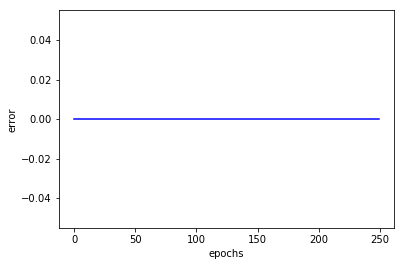

In [20]:
print(type(results_prelim_Mult)); print(len(results_prelim_Mult)); 
plt.plot(np.arange(250), results_prelim_Mult, 'b-')
plt.xlabel('epochs')
plt.ylabel('error')

In [22]:
test_data = reberGrammar.get_n_embedded_examples(10)

In [23]:
predictions_Mult = MemBlck_Mult.predict_on_lst( test_data, verbose=False)

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7f02df4fae90>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

In [25]:
X_test_data,y_test_data=map( list, zip(*test_data) )

In [26]:
assert len(predictions_Mult) == len(y_test_data)
m = len(predictions_Mult)
TOTALELE = 0.
POSRES   = 0.
for j in range(m):
    testing_arr = np.equal( (predictions_Mult[j]>0.5).astype(float) , np.array( y_test_data[j]).astype(float) )
    TOTALELE += testing_arr.size
    POSRES += np.sum( testing_arr )

print POSRES, TOTALELE, POSRES/TOTALELE # 1006.0 1253.0 0.802873104549

1006.0 1253.0 0.802873104549


### More Multiple hidden layers

In [27]:
L_Mult = Gates(g=4,i=3,f=2,o=2)

n_hidden = n_i = n_c = n_o = n_f = 10
n_in = 7 # for embedded reber grammar
n_y = 7 # for embedded reber grammar; this is K in my notation

sg_2 = 9 # s^{(g)}_2, i.e. \alpha = g, gate g, l = 2, layer 2's "size"

s_l_Mult = Gates(g=[n_in,8,9, n_c],i=[n_in,sg_2,n_i],f=[n_in,n_f],o=[n_in,n_o])

activations_Mult = Psis(g=(T.tanh, T.tanh), i=(T.nnet.sigmoid, T.nnet.sigmoid),f=(T.nnet.sigmoid, T.nnet.sigmoid),
                         o=(T.nnet.sigmoid, T.nnet.sigmoid),h=(T.tanh,))

In [31]:
LSTM_model_Mult=LSTM_Model_right(L_Mult,s_l_Mult,n_hidden,n_y,activations_Mult,T.nnet.sigmoid )
lstm_step_fxn_Mult = LSTM_model_Mult.build_lstm_step()
MemBlck_Mult = MemoryBlock_right(n_hidden,LSTM_model_Mult)
MemBlck_Mult.build_scan_over_t()
MemBlck_Mult.build_J(0.5)

Total number of parameters: 23 
Total number of parameters: 23 


Elemwise{add,no_inplace}.0

In [32]:
MemBlck_Mult.build_update(alpha=0.05,beta=0.000001)

Total number of parameters: 23 


In [33]:
%time results_prelim = MemBlck_Mult.train_model_full(train_data,2)  # WITHOUT optimizer_excluding="low_memory"

theano.config.allow_gc =:  False
CPU times: user 27.9 s, sys: 6.76 s, total: 34.7 s
Wall time: 34.7 s


In [34]:
%time results_prelim = MemBlck_Mult.train_model_full(train_data) # theano.config.allow_gc =:  False
#CPU times: user 59min 32s, sys: 16min 6s, total: 1h 15min 38s
#Wall time: 1h 15min 37s


theano.config.allow_gc =:  False
CPU times: user 59min 32s, sys: 16min 6s, total: 1h 15min 38s
Wall time: 1h 15min 37s


In [35]:
predictions_full = MemBlck_Mult.predict_on_lst( test_data, verbose=False)

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float32'}.0, AllocEmpty{dtype='float32'}.0, TensorType(float32, row), TensorType(float32, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7f02fc26bdd0>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 2223, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/topolo/Public/anaconda2/lib/p

In [37]:
assert len(predictions_Mult) == len(y_test_data)
m = len(predictions_Mult)
TOTALELE = 0.
POSRES   = 0.
for j in range(m):
    testing_arr = np.equal( (predictions_Mult[j]>0.5).astype(float) , np.array( y_test_data[j]).astype(float) )
    TOTALELE += testing_arr.size
    POSRES += np.sum( testing_arr )

print POSRES, TOTALELE, POSRES/TOTALELE #  1006.0 1253.0 0.802873104549


 1006.0 1253.0 0.802873104549


In [47]:
print(len(predictions_Mult))
print(type(predictions_Mult[0]));print(predictions_Mult[0].shape)

10
<type 'numpy.ndarray'>
(16, 7)


#### Draft work

In [48]:
g_t_Mul = Feedforward_g_right(3,[7,9,10],n_hidden)
i_t_Mul = Feedforward_ifo_right(3,[7,9,10],n_hidden,T.nnet.sigmoid,T.nnet.sigmoid)
s_L_Mul = [7,9,10][-1]
Thetaby_Mul = Thetab_right(1,[9,7],activation=T.nnet.sigmoid)

In [49]:
## unroll all the parameters
gThetas = [Weight.Theta for Weight in g_t_Mul.Thetabs]
gbs     = [Weight.b for Weight in g_t_Mul.Thetabs]
gthetas = []
for Weight in g_t_Mul.Thetabs:
    try:
        gthetas.append( Weight.theta )
    except AttributeError:
        print("on layer l=%d" % Weight.l)
params_Mul = gThetas + gbs + gthetas
Thetas_only_Mul = gThetas + gthetas

iThetas = [Weight.Theta for Weight in i_t_Mul.Thetabs]
ibs     = [Weight.b for Weight in i_t_Mul.Thetabs]
ithetas = []
for Weight in i_t_Mul.Thetabs:
    try:
        ithetas.append( Weight.theta )
    except AttributeError:
        print("on layer l=%d" % Weight.l)
params_Mul = params_Mul+iThetas + ibs + ithetas

Thetas_only_Mul = Thetas_only_Mul +iThetas + ithetas


on layer l=2
on layer l=2


In [50]:
print(params_Mul)

[Theta1, Theta2, b1, b2, theta1, Theta1, Theta2, b1, b2, theta1]


In [57]:
print(Thetas_only_Mul)
Thetas_only_Mul

[Theta1, Theta2, theta1, Theta1, Theta2, theta1]


[Theta1, Theta2, theta1, Theta1, Theta2, theta1]

In [51]:
def lstm_step_Mul(X_t,h_tm1,c_tm1,*args_for_params):
    g_t= g_t_Mul.connect_through(X_t,h_tm1)
    i_t= i_t_Mul.connect_through(X_t,h_tm1,c_tm1)
    c_t = i_t*g_t
    h_t = activations_Mult.h[-1](c_t)
    Thetaby_Mul.al = h_t
    Thetaby_Mul.connect_through()
    y_t = Thetaby_Mul.alp1
    return [h_t,c_t,y_t]
        

In [52]:
X_Mul = T.matrix(dtype=theano.config.floatX)
c0_Mul = theano.shared(np.zeros(n_hidden).astype(theano.config.floatX))
h0_Mul = T.tanh( c0_Mul )

In [53]:
[h_vals_Mul,c_vals_Mul,y_vals_Mul],updates_from_scan_Mul=theano.scan(fn=lstm_step_Mul, 
                                                                    sequences=dict(input=X_Mul,taps=[0]),
                                                                    outputs_info=[h0_Mul,c0_Mul,None],
                                                                    non_sequences=params_Mul)

In [54]:
#draft work
#lstm_step_Mul(X_Mul,h0_Mul,c0_Mul, *params_Mul)

[Elemwise{tanh,no_inplace}.0, Elemwise{mul,no_inplace}.0, sigmoid.0]

In [55]:
#draft work
#g_t= g_t_Mul.connect_through(X_Mul,h0_Mul)
#i_t= i_t_Mul.connect_through(X_Mul,h0_Mul,c0_Mul)
#c_t = i_t*g_t
#h_t = activations_Mult.h[-1](c_t)
#Thetaby_Mul.al = h_t

In [56]:
#draft work
#Thetaby_Mul.connect_through()

In [59]:
y_Mul=T.matrix(dtype=theano.config.floatX)
J_Mul = build_cost_functional(np.float32(0.1), y_vals_Mul,y_Mul,Thetas_only_Mul)

In [60]:
updateExp_Mul,gradDesc_step_Mul = build_gradDescent_step( J_Mul, params_Mul,X_Mul,y_Mul,0.01,0.0)

Indeed, 

In [69]:
g_t_Mul = Feedforward_g_right(4,[7,8,9,10],n_hidden)


TypeError: 'int' object is not iterable

In [70]:
range(2,4-1)

[2]

## "Gold" version of LSTM, implemented by Herta

In [22]:
dtype=theano.config.floatX
# squashing of the gates should result in values between 0 and 1
# therefore we use the logistic function
sigma = lambda x: 1 / (1 + T.exp(-x))


# for the other activation function we use the tanh
act = T.tanh

# sequences: x_t
# prior results: h_tm1, c_tm1
# non-sequences: W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, W_xy, W_hy, W_cy, b_y
def one_lstm_step(x_t, h_tm1, c_tm1, W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, W_xy, W_ho, W_cy, b_o, W_hy, b_y):
    i_t = sigma(theano.dot(x_t, W_xi) + theano.dot(h_tm1, W_hi) + theano.dot(c_tm1, W_ci) + b_i)
    f_t = sigma(theano.dot(x_t, W_xf) + theano.dot(h_tm1, W_hf) + theano.dot(c_tm1, W_cf) + b_f)
    c_t = f_t * c_tm1 + i_t * act(theano.dot(x_t, W_xc) + theano.dot(h_tm1, W_hc) + b_c) 
    o_t = sigma(theano.dot(x_t, W_xo)+ theano.dot(h_tm1, W_ho) + theano.dot(c_t, W_co)  + b_o)
    h_t = o_t * act(c_t)
    y_t = sigma(theano.dot(h_t, W_hy) + b_y) 
    return [h_t, c_t, y_t]

In [23]:
#TODO: Use a more appropriate initialization method
def sample_weights(sizeX, sizeY):
    values = np.ndarray([sizeX, sizeY], dtype=dtype)
    for dx in xrange(sizeX):
        vals = np.random.uniform(low=-1., high=1.,  size=(sizeY,))
        #vals_norm = np.sqrt((vals**2).sum())
        #vals = vals / vals_norm
        values[dx,:] = vals
    _,svs,_ = np.linalg.svd(values)
    #svs[0] is the largest singular value                      
    values = values / svs[0]
    return values  

In [24]:
n_in = 7 # for embedded reber grammar
n_hidden = n_i = n_c = n_o = n_f = 10
n_y = 7 # for embedded reber grammar

# initialize weights
# i_t and o_t should be "open" or "closed"
# f_t should be "open" (don't forget at the beginning of training)
# we try to archive this by appropriate initialization of the corresponding biases 

W_xi = theano.shared(sample_weights(n_in, n_i))  
W_hi = theano.shared(sample_weights(n_hidden, n_i))  
W_ci = theano.shared(sample_weights(n_c, n_i))  
b_i = theano.shared(np.cast[dtype](np.random.uniform(-0.5,.5,size = n_i)))
W_xf = theano.shared(sample_weights(n_in, n_f)) 
W_hf = theano.shared(sample_weights(n_hidden, n_f))
W_cf = theano.shared(sample_weights(n_c, n_f))
b_f = theano.shared(np.cast[dtype](np.random.uniform(0, 1.,size = n_f)))
W_xc = theano.shared(sample_weights(n_in, n_c))  
W_hc = theano.shared(sample_weights(n_hidden, n_c))
b_c = theano.shared(np.zeros(n_c, dtype=dtype))
W_xo = theano.shared(sample_weights(n_in, n_o))
W_ho = theano.shared(sample_weights(n_hidden, n_o))
W_co = theano.shared(sample_weights(n_c, n_o))
b_o = theano.shared(np.cast[dtype](np.random.uniform(-0.5,.5,size = n_o)))
W_hy = theano.shared(sample_weights(n_hidden, n_y))
b_y = theano.shared(np.zeros(n_y, dtype=dtype))

c0 = theano.shared(np.zeros(n_hidden, dtype=dtype))
h0 = T.tanh(c0)

params = [W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, W_xo, W_ho, W_co, b_o, W_hy, b_y, c0]

In [28]:
#first dimension is time

#input 
v = T.matrix(dtype=dtype)

# target
target = T.matrix(dtype=dtype)

In [16]:
# hidden and outputs of the entire sequence
[h_vals, _, y_vals], _ = theano.scan(fn=one_lstm_step, 
                                  sequences = dict(input=v, taps=[0]), 
                                  outputs_info = [h0, c0, None ], # corresponds to return type of fn
                                  non_sequences = [W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, W_xo, W_ho, W_co, b_o, W_hy, b_y] )


In [17]:
cost = -T.mean(target * T.log(y_vals)+ (1.- target) * T.log(1. - y_vals))


In [18]:
# learning rate
lr = np.cast[dtype](.1)
learning_rate = theano.shared(lr)

In [19]:
gparams = []
for param in params:
  gparam = T.grad(cost, param)
  gparams.append(gparam)

updates=[]
for param, gparam in zip(params, gparams):
    updates.append((param, param - gparam * learning_rate))

In [20]:
learn_rnn_fn = theano.function(inputs = [v, target],
                               outputs = cost,
                               updates = updates)

In [21]:
nb_epochs=250
train_errors = np.ndarray(nb_epochs)
def train_rnn(train_data):      
  for x in range(nb_epochs):
    error = 0.
    for j in range(len(train_data)):  
        index = np.random.randint(0, len(train_data))
        i, o = train_data[index]
        train_cost = learn_rnn_fn(i, o)
        error += train_cost
    train_errors[x] = error 
    
train_rnn(train_data)

(0.0, 50)

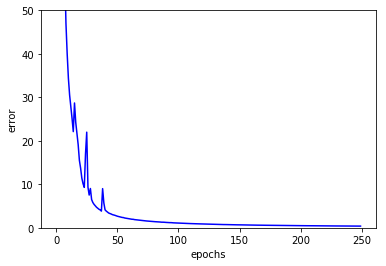

In [22]:
plt.plot(np.arange(nb_epochs), train_errors, 'b-')
plt.xlabel('epochs')
plt.ylabel('error')
plt.ylim(0., 50)

In [23]:
predictions = theano.function(inputs = [v], outputs = y_vals)

test_data = reberGrammar.get_n_embedded_examples(10)

def print_out(test_data):
    for i,o in test_data:
        p = predictions(i)
        print o[-2] # target
        print p[-2] # prediction
        print 
print_out(test_data)

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', AllocEmpty{dtype='float64'}.0, AllocEmpty{dtype='float64'}.0, TensorType(float64, row), TensorType(float64, matrix), 'MergeOptimizer') MergeOptimizer
ERROR (theano.gof.opt): SeqOptimizer apply MergeOptimizer
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 817, in apply
    fgraph.replace_all_validate(pairs, 'MergeOptimizer')
  File "/home/topolo/Public/anaconda2/lib/python2.7/site-packages/the

[ 0.  1.  0.  0.  0.  0.  0.]
[  2.43233675e-06   9.97954670e-01   2.64429935e-04   2.69863801e-04
   1.88016371e-03   1.38660943e-03   5.84324931e-04]

[ 0.  0.  0.  0.  1.  0.  0.]
[  1.96756615e-07   1.35325788e-03   2.84242201e-04   3.04241353e-04
   9.96710433e-01   6.36753491e-05   1.95325091e-03]

[ 0.  0.  0.  0.  1.  0.  0.]
[  1.76485516e-07   2.35432124e-03   4.16199149e-04   4.49826060e-04
   9.96645648e-01   7.17373631e-05   1.36849868e-03]

[ 0.  1.  0.  0.  0.  0.  0.]
[  4.60176790e-06   9.98925203e-01   3.35967186e-04   3.36846540e-04
   3.46051278e-04   1.78814571e-03   7.52967155e-04]

[ 0.  0.  0.  0.  1.  0.  0.]
[  1.87858571e-07   1.62966322e-03   3.50517392e-04   3.77439644e-04
   9.96757444e-01   6.03820571e-05   1.67574070e-03]

[ 0.  0.  0.  0.  1.  0.  0.]
[  1.55065438e-07   4.00838690e-03   3.44138005e-04   3.73617135e-04
   9.96538249e-01   7.98475749e-05   1.17616860e-03]

[ 0.  0.  0.  0.  1.  0.  0.]
[  2.10236734e-07   1.40785547e-03   4.73173202e-04 

In [24]:
def print_out(test_data):
    for i,o in test_data:
        p = predictions(i)
        print np.argmax( o[-2] ) # target
        print np.argmax( p[-2] ) # prediction
        print 
print_out(test_data)

1
1

4
4

4
4

1
1

4
4

4
4

4
4

1
1

4
4

4
4



In [15]:
test_data = reberGrammar.get_n_embedded_examples(10)

In [16]:
print(type(test_data));print( len( test_data));
print( type( test_data[0][1] )); print( len(test_data[0][1])); test_data[0][1]

<type 'list'>
10
<type 'list'>
14


[array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.])]

In [27]:
b_i.get_value().shape

(10,)

In [14]:
sys.path.append( os.getcwd() + '/ML' )

In [15]:
LSTM_model_Herta= LSTM_Model_right( L_Herta, s_l_Herta, n_hidden, n_y, activations_Herta, T.nnet.sigmoid)

Total number of parameters: 17 


In [18]:
len( LSTM_model_Herta.params )

17

In [30]:
lstm_step_fxn = LSTM_model_Herta.build_lstm_step()

In [33]:
[h_vals_EY, _, y_vals_EY], _ = theano.scan(fn=lstm_step_fxn_EY, sequences=dict(input=v,taps=[0]), outputs_info=[h0,c0,None], 
               non_sequences = LSTM_model_Herta.params, 
               allow_gc=False) # comment this out to check if this flag helps or not

In [34]:
cost_EY = -T.mean(target * T.log(y_vals_EY) + (1.-target )* T.log(1.-y_vals_EY))

In [37]:
gparams_EY = []
params_EY = LSTM_model_Herta.params
for param in params_EY:
  gparam = T.grad(cost_EY, param)
  gparams_EY.append(gparam)

updates_EY=[]
for param, gparam in zip(params_EY, gparams_EY):
    updates_EY.append((param, param - gparam * np.float32(0.1)))

In [41]:
print( len(train_data) )
learn_rnn_fn_EY = theano.function(inputs=[v,target],outputs=cost_EY,updates = updates_EY)

1000


In [42]:
nb_epochs=250
train_errors = np.ndarray(nb_epochs)
def train_rnn_EY(train_data):      
  for j in range(nb_epochs):
    error = 0.
    for t in range(len(train_data)):  
        index = np.random.randint(0, len(train_data))
        i, o = train_data[index]
        train_cost = learn_rnn_fn_EY(i, o)
        error += train_cost
    train_errors[x] = error 

In [43]:
train_rnn_EY(train_data)

ValueError: dimension mismatch in args to gemv (10,7)x(10)->(10)
Apply node that caused the error: GpuGemv{no_inplace}(b1_copy[cuda], TensorConstant{1.0}, GpuDimShuffle{1,0}.0, GpuElemwise{Composite{(scalar_sigmoid((i0 + i1)) * tanh(i2))},no_inplace}.0, TensorConstant{1.0})
Toposort index: 31
Inputs types: [CudaNdarrayType(float32, vector), TensorType(float32, scalar), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector), TensorType(float32, scalar)]
Inputs shapes: [(10,), (), (10, 7), (10,), ()]
Inputs strides: [(1,), (), (1, 10), (1,), ()]
Inputs values: ['not shown', array(1.0, dtype=float32), 'not shown', 'not shown', array(1.0, dtype=float32)]
Outputs clients: [[GpuElemwise{scalar_sigmoid,no_inplace}(GpuGemv{no_inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: forall_inplace,gpu,scan_fn}(Shape_i{0}.0, GpuSubtensor{int64:int64:int8}.0, GpuIncSubtensor{Set;:int64:}.0, GpuIncSubtensor{InplaceSet;:int64:}.0, Shape_i{0}.0, Theta1, b1, theta1, Theta1, b1, theta1, W1, Theta1, b1, theta1, W1, Theta1, b1, theta1, W1, Theta1, b1)
Toposort index: 115
Inputs types: [TensorType(int64, scalar), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), TensorType(int64, scalar), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector)]
Inputs shapes: [(), (21, 7), (22, 10), (22, 10), (), (7, 10), (10,), (10, 10), (7, 10), (10,), (10, 10), (10, 10), (7, 10), (10,), (10, 10), (10, 10), (7, 10), (10,), (10, 10), (10, 10), (7, 10), (10,)]
Inputs strides: [(), (7, 1), (10, 1), (10, 1), (), (10, 1), (1,), (10, 1), (10, 1), (1,), (10, 1), (10, 1), (10, 1), (1,), (10, 1), (10, 1), (10, 1), (1,), (10, 1), (10, 1), (10, 1), (1,)]
Inputs values: [array(21), 'not shown', 'not shown', 'not shown', array(21), 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown']
Outputs clients: [[GpuSubtensor{int64:int64:int64}(forall_inplace,gpu,scan_fn}.0, ScalarFromTensor.0, ScalarFromTensor.0, Constant{-1}), GpuSubtensor{int64:int64:int64}(forall_inplace,gpu,scan_fn}.0, ScalarFromTensor.0, ScalarFromTensor.0, Constant{-1})], [GpuSubtensor{int64:int64:int64}(forall_inplace,gpu,scan_fn}.1, ScalarFromTensor.0, ScalarFromTensor.0, Constant{-1}), GpuSubtensor{int64:int64:int64}(forall_inplace,gpu,scan_fn}.1, ScalarFromTensor.0, ScalarFromTensor.0, Constant{-1})], [GpuSubtensor{int64:int64:int64}(forall_inplace,gpu,scan_fn}.2, ScalarFromTensor.0, ScalarFromTensor.0, Constant{-1}), GpuElemwise{sub,no_inplace}(CudaNdarrayConstant{[[ 1.]]}, forall_inplace,gpu,scan_fn}.2), GpuElemwise{Composite{((i0 * log(i1)) + (i2 * log(i3)))}}[(0, 0)](GpuFromHost.0, forall_inplace,gpu,scan_fn}.2, GpuElemwise{sub,no_inplace}.0, GpuElemwise{sub,no_inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [11]:
import LSTM
from LSTM import Gates, Psis, LSTM_Model, MemoryBlock

In [16]:
L_Herta = Gates(g=2,i=2,f=2,o=2)
s_l_Herta = Gates(g=[n_in,n_c],i=[n_in,n_i],f=[n_in,n_f],o=[n_in,n_o])
activations_Herta = Psis(g=(T.tanh, T.tanh), i=(T.nnet.sigmoid, T.nnet.sigmoid),f=(T.nnet.sigmoid, T.nnet.sigmoid),
                         o=(T.nnet.sigmoid, T.nnet.sigmoid),h=(T.tanh,))

In [19]:
LSTM_model_Herta= LSTM_Model( L_Herta, s_l_Herta, activations_Herta, T.nnet.sigmoid, n_y)
lstm_step_fxn = LSTM_model_Herta.build_lstm_step()
MemBlck_Herta = MemoryBlock(LSTM_model_Herta)

Total number of parameters: 17 


In [31]:
theano.scan(fn=lstm_step_fxn, sequences=dict(input=v,taps=[0]),outputs_info =[h0,c0,None])

ValueError: get_scalar_constant_value detected deterministic IndexError: x.shape[1] when x.ndim=1. x=Subtensor{int64}.0

In [33]:
os.getcwd()

'/home/topolo/PropD/MLgrabbag'

In [35]:
os.listdir('../')

['CUDACFD_out',
 'servetheloop',
 'cantera',
 'CompPhys',
 'thermopy',
 '.ipynb_checkpoints',
 'setup.py.in',
 'Propulsion',
 'tensorflow',
 'DeepLearningTutorials',
 'NISTchemwb',
 'cfcf3d',
 'cs344',
 'MLgrabbag',
 'OpenNN',
 'thrust']

In [36]:
sys.path.append( '../DeepLearningTutorials/code' )

In [37]:
import lstm

In [55]:
from lstm import *

In [42]:
n_words=10000,  # Vocabulary size
maxlen=100,  # Sequence longer then this get ignored

In [61]:
dataset='imdb'
load_data, prepare_data = get_dataset(dataset)

In [43]:
train, valid, test = load_data(n_words=n_words, valid_portion=0.05,maxlen=maxlen)

In [47]:
print(type(load_data)); print(type(prepare_data)); print(type(train)); print(type(valid)); print(type(test))
print(len(train)); print(len(valid)); print(len(test))
print(type(train[0])); print(type(valid[0])); print(type(test[0]));
print(len(train[0])); print(len(valid[0])); print(len(test[0]))

<type 'function'>
<type 'function'>
<type 'tuple'>
<type 'tuple'>
<type 'tuple'>
2
2
2
<type 'list'>
<type 'list'>
<type 'list'>
23750
1250
25000


In [62]:
# create the initial parameters as numpy ndarrays
model_options=locals().copy()
ydim = numpy.max(train[1]) +1
model_options['ydim']=ydim
params = init_params(model_options)

KeyError: 'dim_proj'

In [49]:
help(locals)

Help on built-in function locals in module __builtin__:

locals(...)
    locals() -> dictionary
    
    Update and return a dictionary containing the current scope's local variables.



In [59]:
# This create Theano Shared Variable from the parameters.
    # Dict name (string) -> Theano Tensor Shared Variable
    # params and tparams have different copy of the weights.
tparams = lstm.init_tparams(params)

AttributeError: 'list' object has no attribute 'items'

In [63]:
#train_lstm()

model options {'encoder': 'lstm', 'optimizer': <function adadelta at 0x7fcfacdbbed8>, 'validFreq': 370, 'lrate': 0.0001, 'batch_size': 16, 'decay_c': 0.0, 'patience': 10, 'reload_model': None, 'n_words': 10000, 'max_epochs': 5000, 'dispFreq': 10, 'dataset': 'imdb', 'valid_batch_size': 64, 'use_dropout': True, 'dim_proj': 128, 'maxlen': 100, 'saveto': 'lstm_model.npz', 'noise_std': 0.0, 'test_size': -1, 'saveFreq': 1110}
Loading data
Building model
Optimization
1998 train examples
105 valid examples
25000 test examples
Epoch  0 Update  10 Cost  0.692698359489
Epoch  0 Update  20 Cost  0.691576838493
Epoch  0 Update  30 Cost  0.678899407387
Epoch  0 Update  40 Cost  0.69440060854
Epoch  0 Update  50 Cost  0.683119535446
Epoch  0 Update  60 Cost  0.702967643738
Epoch  0 Update  70 Cost  0.665298700333
Epoch  0 Update  80 Cost  0.699218034744
Epoch  0 Update  90 Cost  0.670724391937
Epoch  0 Update  100 Cost  0.671119213104
Epoch  0 Update  110 Cost  0.723990380764
Epoch  0 Update  120 Cos

Training took 456.9s


(0.0, 0.10476190476190472, 0.22092000000000001)

In [64]:
    dim_proj=128,  # word embeding dimension and LSTM number of hidden units.
    patience=10,  # Number of epoch to wait before early stop if no progress
    max_epochs=5000,  # The maximum number of epoch to run
    dispFreq=10,  # Display to stdout the training progress every N updates
    decay_c=0.,  # Weight decay for the classifier applied to the U weights.
    lrate=0.0001,  # Learning rate for sgd (not used for adadelta and rmsprop)
    n_words=10000,  # Vocabulary size
    optimizer=adadelta,  # sgd, adadelta and rmsprop available, sgd very hard to use, not recommanded (probably need momentum and decaying learning rate).
    encoder='lstm',  # TODO: can be removed must be lstm.
    saveto='lstm_model.npz',  # The best model will be saved there
    validFreq=370,  # Compute the validation error after this number of update.
    saveFreq=1110,  # Save the parameters after every saveFreq updates
    maxlen=100,  # Sequence longer then this get ignored
    batch_size=16,  # The batch size during training.
    valid_batch_size=64,  # The batch size used for validation/test set.
    dataset='imdb',

    # Parameter for extra option
    noise_std=0.,
    use_dropout=True,  # if False slightly faster, but worst test error
                       # This frequently need a bigger model.
    reload_model=None,  # Path to a saved model we want to start from.
    test_size=-1,  # If >0, we keep only this number of test example.

In [ ]:
    # Model options
    model_options = locals().copy()
    print("model options", model_options)

    load_data, prepare_data = get_dataset(dataset)

    print('Loading data')
    train, valid, test = load_data(n_words=n_words, valid_portion=0.05,
                                   maxlen=maxlen)
    if test_size > 0:
        # The test set is sorted by size, but we want to keep random
        # size example.  So we must select a random selection of the
        # examples.
        idx = numpy.arange(len(test[0]))
        numpy.random.shuffle(idx)
        idx = idx[:test_size]
        test = ([test[0][n] for n in idx], [test[1][n] for n in idx])

    ydim = numpy.max(train[1]) + 1

    model_options['ydim'] = ydim

    print('Building model')
    # This create the initial parameters as numpy ndarrays.
    # Dict name (string) -> numpy ndarray

In [ ]:
params = init_params(model_options)

In [33]:
T.matrix().astype(theano.config.floatX)

<TensorType(float64, matrix)>

In [37]:
theano.shared(np.zeros(9)).astype(theano.config.floatX)

<TensorType(float64, vector)>

## copies of the classes defined in `LSTM_Herta.py`

In [20]:
%time j_test_time = 3+2

CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 17.2 µs


In [21]:
j_test_time

5

In [12]:
Gates = namedtuple("Gates",['g','i','f','o'])
Psis = namedtuple("Psis",['g','i','f','o','h'])

In [ ]:
class Thetab_right(object):
def __init__(self, l, s_ls, al=None, Theta=None, b=None, activation=T.tanh, rng=None ):
        s_lp1, s_l = s_ls

        if rng is None:
            rng = np.random.RandomState(1234)

        if Theta is None:
            Theta_values = np.asarray( 
            rng.uniform( 
					low=-np.sqrt(6. / ( s_l + s_lp1 )), 
					high=np.sqrt(6. / ( s_l + s_lp1 )), size=(s_l, s_lp1) ), 
					dtype=theano.config.floatX 
			)
			if activation == T.nnet.sigmoid:
				Theta_values *= np.float32( 4 )
			
			Theta = theano.shared(value=Theta_values, name="Theta"+str(l), borrow=True)
		

		if b is None:
			b_values =  np.zeros(s_lp1).astype(theano.config.floatX)
			b= theano.shared(value=b_values, name='b'+str(l), borrow=True)	
			
		if al is None:
			al = T.matrix(dtype=theano.config.floatX)
			
			
		self.Theta = Theta  # size dims. (s_l,s_lp1) i.e. s_l x s_lp1
		self.b     = b      # dims. s_lp1
		self.al    = al     # dims. s_l
		
		self.l     = l

		if activation is None:
			self.psi = None
		else:
			self.psi = activation
	

	def connect_through(self):
		""" connect_through

			Note that I made connect_through a separate class method, separate from the automatic initialization, 
			because you can then make changes to the "layer units" or "nodes" before "connecting the layers"
				"""
# my attempt at left action version; T.tile made problems for scan 
#		lin_zlp1 = T.dot( self.Theta, self.al)+T.tile(self.b, (1,self.al.shape[1].astype('int32') ) ) # z^{(l+1)}
		lin_zlp1 = T.dot( self.al, self.Theta) + self.b
		if self.psi is None:
			self.alp1 = lin_zlp1
		else:
			self.alp1 = self.psi( lin_zlp1 )


In [40]:
test_data[0][0]

[array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.])]

In [41]:
test_data[0][1]

[array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.]),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.])]

In [43]:
X_test_data[0]

[array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.])]

In [48]:
dir(theano.sandbox)

['__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '__path__',
 'cuda',
 'gpuarray',
 'multinomial',
 'rng_mrg']